# 불균형 데이터로 신용카드 사기탐지 모델 구현하기

## Step 0. 사기탐지 분류 모형 개요

### 금융 데이터의 특성 (Review)
- 1) 이종(heterogeneous) 데이터의 결합
- 2) <b>분포의 편향성(skewness)</b>
- 3) 분류 레이블의 불명확성
- 4) 변수의 다중공선성(multicollinearity)
- 5) 변수의 비선형성
- 그 외 현실적인 규제·수집·저장 등의 한계 때문에 데이터가 불완전(missing, truncated, censored)할 수 있음

사기탐지(Fraud Detection) 분류는 주로 2)와 관련한 금융 데이터의 특성을 가진 문제입니다. 

### 불균형 데이터의 머신러닝

- 데이터 불균형(Imbalanced Data): 머신러닝의 지도학습에서 분류하기 위한 각 클래스(레이블)에 해당하는 데이터의 양에 차이가 큰 경우
- 특정 클래스가 부족할 때 생기는 문제: (1) 과대적합, (2) 알고리즘이 수렴하지 않는 현상 발생


- 1) X (피처)의 불균형
    - 범주변수일 경우 범주에 따라 빈도가 낮을 수 있음
    - 고차원 피처 공간의 축소(Feature Transformation)
    - PCA, t-SNE 등의 알고리즘 사용
    
    
- 2) y (타겟)의 불균형
    - 여신(대출), 수신(적금), 보험(클레임), 카드(사기탐지), 거시경제(불황) 등 대부분의 금융 데이터는 희소 타겟 문제
    - 리샘플링(Resampling)으로 저빈도 데이터를 극복
    - 무선 과대표집(Random Oversampling), 무선 과소표집(Random Undersampling), SMOTE, Tomek Links 등의 알고리즘 사용

### 학습목표

- 1) 불균형 데이터 분류 문제에 대한 이해
- 2) 피처 변환 알고리즘의 이해
- 3) 과대적합 발생시 해결 방법 습득
- 4) 리샘플링 알고리즘에 대한 이해
- 5) 불균형 데이터를 이용한 분류 결과의 올바른 해석 방법 습득

## Step 1. 데이터를 학습에 맞게 변환하기

- 데이터 소개
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [3]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [4]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [140]:
pip install scikit-learn==0.23.1
pip install imbalanced-learn==0.7.0

SyntaxError: invalid syntax (<ipython-input-140-afd19d7806da>, line 1)

In [1]:
pip install scikit-learn == 0.23.1


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '=='


In [2]:
pip install imbalanced-learn == 0.7.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '=='


In [6]:
import warnings
warnings.filterwarnings("ignore")

### 문제 01. 데이터 확인하기

In [ ]:
filepath = 'https://github.com/mchoimis/financialml/raw/main/fraud/'

In [7]:
# 파일 불러오기
df = pd.read_csv('fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
# 로드한 데이터의 맨 윗 30개 행 확인하기
df.head(30)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [9]:
# Missing 여부 확인하기
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [11]:
# 불러온 데이터의 클래스 분포 확인하기
df.Class.value_counts()  


0    284315
1       492
Name: Class, dtype: int64

In [12]:
print('Target class is ', '{0:0.4f}'. format(492/(492+284315)*100 ), '%')

Target class is  0.1727 %


### 문제 02. 변수의 스케일 변환하기

### 참고: scikit-learn이 제공하는 스케일러 (Review)

scikit-learn에서 제공하는 피처 스케일러(scaler)
- `StandardScaler`: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- `RobustScaler`: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- `MinMaxScaler`: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- `Normalizer`: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

<p> 스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문입니다. <b> 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 합니다. </b>
    
<p> 반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있습니다. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있습니다. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있습니다.
    
<p> <b>스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것입니다.</b> 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있습니다. 이 점을 함께 고려하시면 좋겠습니다.

df.Amount.values.reshape(-1,1) 의 -1은 알아서 적절한 모양으로 만들어 준다

In [13]:
# 데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()


df['scaled_amount'] = rob_scaler.fit_transform(df[['Amount']])
df['scaled_time'] =  std_scaler.fit_transform(df[['Time']])

# 원 데이터에서 Time 컬럼과 Amount 컬럼 제외하기
df.drop(['Time','Amount'], axis = 1, inplace =True)

In [14]:
# 스케일 조정된 컬럼 추가하기
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

## 스케일 조정된 데이터 확인하기


In [15]:
df.describe()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,0.927124,-1.050379e-14,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,...,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,0.001727
std,3.495006,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,-0.307413,-1.996583e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-0.229162,-8.552120e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,0.000000,-2.131453e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,0.770838,9.372174e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,358.683155,1.642058e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


### 문제 03. 샘플 데이터 나누기

In [16]:
# X와 y 데이터 셋 만들기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

# 층위 샘플링으로 데이터 나누기
sss = StratifiedShuffleSplit(n_splits = 5, random_state = None)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

#5번 반복해서 추출, 그걸로 매번 데이터로 학습을 시킬 것이다. iloc은 열이 아니라 행을 추출하기 위해 사용
#일반적으로 하는 방법이다
print( original_Xtrain.shape, original_Xtest.shape)

  # 채워주세요


(256326, 30) (28481, 30)


In [17]:
# 클래스의 skew 정도가 매우 높기 때문에 클래스간 분포를 맞추는 것이 필요합니다.
# subsample 구축 전 셔플링을 통해 레이블이 한쪽에 몰려있지 않도록 하겠습니다.
df = df.sample(frac=1)#fraction은 비율이다 sample로 이미 무작위 추출함

# 데이터 준비
fraud_df =  df[df.Class == 1]
non_fraud_df =  df[df.Class == 0][:492]

normal_distributed_df = pd.concat([fraud_df,non_fraud_df])

# 데이터 (다시)셔플하기
new_df =  normal_distributed_df.sample(frac=1)

# 셔플한 새로운 데이터 셋 확인
new_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
8615,-0.293440,-1.751700,-3.891192,7.098916,-11.426467,8.607557,-2.065706,-2.985288,-8.138589,2.973928,...,1.382619,1.757085,-0.189709,-0.508629,-1.189308,1.188536,0.605242,1.881529,0.875260,1
150384,-0.307413,-0.032932,1.948552,0.680123,-0.706003,3.561845,1.169180,1.191006,-0.106483,0.054729,...,-0.185835,-0.152823,-0.117914,0.140787,-0.272739,-0.010695,-0.135909,-0.046155,-0.059040,0
153823,-0.275554,0.113905,-19.641857,14.706335,-22.801238,12.114672,-14.898113,0.840778,-28.011293,-11.919639,...,3.834649,-8.228874,3.318178,2.585212,0.195009,-1.194803,0.038423,-4.126746,-0.645329,1
110997,1.840145,-0.479275,1.123233,-0.922807,0.051259,-0.448001,-1.199632,-1.114103,-0.167249,-0.290104,...,-0.223940,-0.306474,-0.757920,-0.075431,0.404468,0.198953,1.027306,-0.097456,0.028581,0
140218,0.331866,-0.236141,-5.514249,2.643658,0.709556,-0.647294,2.430647,2.507469,-6.432118,-11.046498,...,-3.289571,11.338354,-4.327290,-2.646431,-0.960415,-0.579137,0.310529,0.777435,0.338329,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102445,-0.293440,-0.560285,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,...,-3.493050,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1
17041,2.148397,-1.398812,1.088541,-0.968175,-0.072120,-0.710237,-0.857370,-0.605058,-0.239014,-0.179444,...,0.440856,0.345072,0.537346,-0.315131,0.053588,0.592805,-0.131874,-0.039559,0.026180,0
172726,1.574093,0.555995,-0.896219,-0.624888,0.068228,-2.245144,0.080255,-1.077672,0.929390,-0.352884,...,0.211778,0.470096,1.688530,0.207892,0.035471,-0.284064,-0.155366,0.423607,0.076891,0
203328,12.622232,0.841372,-0.967767,2.098019,-5.222929,6.514573,-4.187674,2.114178,0.948701,-2.448427,...,1.147204,-0.843268,0.796739,1.314312,-0.352887,-1.770706,0.098133,0.956769,0.162777,1


## Step 2. PCA와 t-SNE, SVD를 이용하여 차원 축소하기

### 참고: 차원축소 방법
    
- 주성분 분석(Principal Component Analysis)
- t-SNE (Stochastic Neighbor Embedding)
    - SNE는 n 차원에 분포된 이산 데이터를 k(n 이하의 정수) 차원으로 축소하며 거리 정보를 보존하되, 거리가 가까운 데이터의 정보를 우선하여 보존하기 위해 고안되었음
    - 단어 벡터와 같이 고차원 데이터를 시각화하는 데 가장 자주 쓰이는 알고리즘
    - SNE 학습과정에 사용되는 가우시안 분포는 t 분포에 비해 거리에 따른 확률 값 변화의 경사가 가파른 특징을 가지기 때문에 특정 거리 이상부터는 학습과정에 거의 반영이 되지 않는 문제점을 가지고 있음(Crowding Problem)
    - 이러한 문제점을 보완하기 위해 고안된 방법이 t-SNE: 학습과정에서 가우시안 분포 대신 t 분포를 이용
    - t-SNE는 보통 word2vec으로 임베딩한 단어벡터를 시각화하는데 쓰임
    
- 특이값 분해(Singular Value Decomposition)
- 그 외 잠재 의미분석(Latent Semantic Analysis), 행렬 인수분해(Matrix Factorization) 등

실무에서는 스케일이 매우 큰 실제 데이터를 분석하기 위해서, 여러 방법론을 융합하여 사용하는 것이 필요

### 문제 04. 차원 축소하기

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# 차원 축소할 데이터 준비
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# t-SNE  
X_reduced_tsne = TSNE(n_components =2).fit_transform(X.values)   # hint: n_components == 임베딩 공간의 차원 크기 
print('t-SNE done')

# PCA 
X_reduced_pca = PCA(n_components = 2).fit_transform(X.values)     # hint: n_components == 임베딩 공간의 차원 크기 
print('PCA done')

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components = 2).fit_transform(X.values)    # hint: n_components == 임베딩 공간의 차원 크기 
print('Truncated SVD done')

t-SNE done
PCA done
Truncated SVD done


### 문제 05. 결과 시각화하기

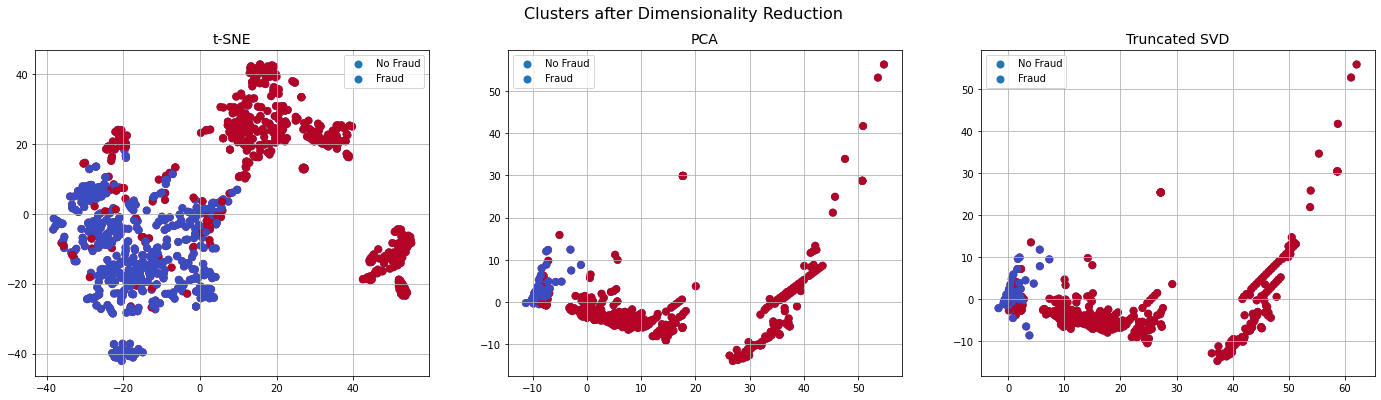

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Clusters after Dimensionality Reduction', fontsize=16)

# Label 범례 설정
labels = ['Fraud', 'No Fraud']
blue_patch = mpatches.Patch(color = 'blue', label = 'No Fraud')
red_patch = mpatches.Patch(color = 'red', label = 'Fraud' )

# t-SNE scatter plot
#우선, reduce하는 과정에서 x는 2개 값으로 되었다. 따라서 밑에는 2개를 넣어준다 ([:,0], [:,1]로)
ax1.scatter( X_reduced_tsne[:,0],X_reduced_tsne[:,1] ,c=(y==0) , cmap='coolwarm', label='No Fraud', linewidths=2) ###
ax1.scatter( X_reduced_tsne[:,0],X_reduced_tsne[:,1], c=(y==1) , cmap='coolwarm', label='Fraud', linewidths=2) ###
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend( ) ###

# PCA scatter plot
ax2.scatter( X_reduced_pca[:,0],X_reduced_pca[:,1] ,c =(y==0) , cmap='coolwarm', label='No Fraud', linewidths=2) ###
ax2.scatter( X_reduced_pca[:,0],X_reduced_pca[:,1] ,c =(y==1) ,cmap='coolwarm', label='Fraud', linewidths=2) ###
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend( ) ###

# TruncatedSVD scatter plot (사실 전부 scatter가 한줄만 있어도 된다)
ax3.scatter(X_reduced_svd[:,0],X_reduced_svd[:,1] ,  c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2) ###
ax3.scatter(X_reduced_svd[:,0],X_reduced_svd[:,1] , c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2) ###
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend( ) ###

plt.show()

## Step 3. Random Undersampling 으로 샘플 재구축하기

### 문제 06. 재구축 샘플로 분류모델 구현하기

In [21]:
# 재구축한 데이터의 클래스 분포 확인하기
print(new_df.describe())
new_df.Class.value_counts()

       scaled_amount  scaled_time          V1          V2          V3  \
count     984.000000   984.000000  984.000000  984.000000  984.000000   
mean        1.302942    -0.190514   -2.426520    1.812595   -3.516873   
std         4.203827     0.995521    5.543018    3.723444    6.231659   
min        -0.307413    -1.988034  -30.552380  -21.001073  -31.103685   
25%        -0.285370    -1.069629   -2.885484   -0.168855   -5.138122   
50%         0.003563    -0.345884   -0.821079    0.956122   -1.411803   
75%         1.089779     0.762510    1.038457    2.833075    0.373312   
max        67.625795     1.616346    2.331834   22.057729    3.648776   

               V4          V5          V6          V7          V8  ...  \
count  984.000000  984.000000  984.000000  984.000000  984.000000  ...   
mean     2.281573   -1.655088   -0.645381   -2.731531    0.238808  ...   
std      3.188650    4.257948    1.884607    5.959748    4.906543  ...   
min     -3.825124  -22.105532   -6.406267  -43

0    492
1    492
Name: Class, dtype: int64

In [22]:
# X와 y 데이터 셋 만들기
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [23]:
# 언더샘플링을 위한 샘플 데이터 구축
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
# 모델 인풋에 들어가기 위한 데이터의 형태 바꾸기
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [25]:
# 학습시킬 모델 로드하기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "K Nearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "LightGBM Classifier": LGBMClassifier()
}

In [26]:
# 모델별 cross validation 한 결과의 평균 정확도 점수 출력하기
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LogisticRegression : 93.0 % accuracy
KNeighborsClassifier : 92.0 % accuracy
SVC : 93.0 % accuracy
DecisionTreeClassifier : 91.0 % accuracy
RandomForestClassifier : 93.0 % accuracy
GradientBoostingClassifier : 93.0 % accuracy
LGBMClassifier : 93.0 % accuracy


### 문제 07. 분류 결과 확인하기

In [113]:
### 올바른 예

In [34]:
# 모델별 분류결과 확인하기 (올바른 예)
from sklearn.metrics import classification_report
#즉, 이전에 가지고 있던 오리지널 데이터를 넣어서 모델을 확인해야 한다.
for key, classifier in classifiers.items():
    y_pred =   classifier.predict(original_Xtest)
    results =   classification_report(original_ytest,y_pred)
    print(classifier.__class__.__name__, '-------','\n', results)

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     28432
           1       0.05      0.94      0.09        49

    accuracy                           0.97     28481
   macro avg       0.52      0.95      0.54     28481
weighted avg       1.00      0.97      0.98     28481

KNeighborsClassifier ------- 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     28432
           1       0.06      0.90      0.12        49

    accuracy                           0.98     28481
   macro avg       0.53      0.94      0.55     28481
weighted avg       1.00      0.98      0.99     28481

SVC ------- 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     28432
           1       0.10      0.88      0.19        49

    accuracy                           0.99     28481
   macro avg       0.55      0.93      0.59     28481


In [35]:
# 모델별 Confusion Matrix 확인하기 (올바른 예)
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred = classifier.predict(original_Xtest)
    cm =   confusion_matrix(original_ytest,y_pred)
    print(classifier.__class__.__name__, '\n', cm, '\n')

LogisticRegression 
 [[27520   912]
 [    3    46]] 

KNeighborsClassifier 
 [[27779   653]
 [    5    44]] 

SVC 
 [[28064   368]
 [    6    43]] 

DecisionTreeClassifier 
 [[25248  3184]
 [    0    49]] 

RandomForestClassifier 
 [[28036   396]
 [    1    48]] 

GradientBoostingClassifier 
 [[27479   953]
 [    0    49]] 

LGBMClassifier 
 [[27507   925]
 [    1    48]] 



In [ ]:
### 잘못된 예

In [30]:
# 모델별 분류결과 확인하기 (잘못된 예)
from sklearn.metrics import classification_report

for key, classifier in classifiers.items():
    y_pred =   classifier.predict(X_test)
    results_wrong =   classification_report(y_test, y_pred)
    print(classifier.__class__.__name__, '-------','\n', results_wrong)
#잘못된 이유는 테스트를 데이터 197개 밖에 사용한 것이다. 결국 테스트 시에는 전체
#데이터를 활용하는 것이 적절하다.

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95        90
           1       0.98      0.93      0.95       107

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197

KNeighborsClassifier ------- 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95        90
           1       0.99      0.92      0.95       107

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197

SVC ------- 
               precision    recall  f1-score   support

           0       0.87      0.99      0.93        90
           1       0.99      0.88      0.93       107

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197


In [32]:
# 모델별 Confusion Matrix 확인하기 (잘못된 예)
#confusion matrix란, 실제 1,0 / 예측1,0 을 2*2 표로 나타낸 것이다
#즉, 대각선 수가 높을수록 좋은 모델(1,1 / 2,2)
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred =   classifier.predict(X_test)
    cm_wrong =   confusion_matrix(y_test, y_pred)
    print(classifier.__class__.__name__, '\n', cm_wrong, '\n')

LogisticRegression 
 [[88  2]
 [ 8 99]] 

KNeighborsClassifier 
 [[89  1]
 [ 9 98]] 

SVC 
 [[89  1]
 [13 94]] 

DecisionTreeClassifier 
 [[ 79  11]
 [  7 100]] 

RandomForestClassifier 
 [[89  1]
 [10 97]] 

GradientBoostingClassifier 
 [[86  4]
 [ 9 98]] 

LGBMClassifier 
 [[86  4]
 [10 97]] 



## Step 4. SMOTE 로 Oversampling 하기 

### 참고:

- 리샘플링(Synthetic Minority Oversampling Technique)

- 모델 파라미터 조정
    - `scale_pos_weight`
    - `is_unbalance`
    - `{class_label: weight}`

### 문제 08. SMOTE로 Oversampling하기

In [43]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_resampled, y_resampled = sm.fit_resample(original_Xtrain,original_ytrain)


print('Before SMOTE, original X_train: {}'.format(original_Xtrain.shape)) 
print('Before SMOTE, original y_train: {}'.format(np.array(original_ytrain).shape))
print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape)) 
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     fraud counts: {}".format(sum(np.array(original_ytrain)==1)))
print("Before SMOTE, non-fraud counts: {}".format(sum(np.array(original_ytrain)==0)))
print("After  SMOTE,     fraud counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-fraud counts: {}".format(sum(np.array(y_resampled)==0)))

Before SMOTE, original X_train: (256326, 30)
Before SMOTE, original y_train: (256326,)
After  SMOTE, resampled original X_train: (511766, 30)
After  SMOTE, resampled original y_train: (511766,) 

Before SMOTE,     fraud counts: 443
Before SMOTE, non-fraud counts: 255883
After  SMOTE,     fraud counts: 255883
After  SMOTE, non-fraud counts: 255883


### 문제 09. 재구축한 샘플로 분류 모형 구현하기(2가지 방법)

In [38]:
# 방법 1: 모델의 파라미터를 조정하는 방법 

In [39]:
from sklearn.metrics import accuracy_score, recall_score
# f1_score, roc_auc_score, precision_score

In [55]:
# Logistic Regression 모델의 weight 파라미터 지정하기
#smote 로 조율한 데이터 활용이 아닌 이전 original 데이터를 활용
w = {0:1,1:99} ## 불균형 클래스 weight 파라미터 지정
#사기인데 사기가 아니라 하는 것이 매우 중요

# 모델 피팅
logreg_weighted =  LogisticRegression(random_state = 0, class_weight=w)
logreg_weighted.fit(original_Xtrain, original_ytrain)

# 예측값 구하기
y_pred =  logreg_weighted.predict(original_Xtest)

# 예측 결과값 확인하기 3가지 방법으로 확인. 
print('Logistic Regression ------ Weighted')
print(f'Accuracy: {accuracy_score(original_ytest,y_pred) }')###

print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(original_ytest, y_pred) }')###

print('\n')
print(f'Recall: {recall_score(original_ytest, y_pred) }')###
#recall 이 높아질수록 사기가 아닌데 사기라고 판단하는 확률이 올라감. 대신 사기인데 사기가 아니라고 판단하는 확률이 감소 (우리가 추구하는 방향이다)

Logistic Regression ------ Weighted
Accuracy: 0.9959973315543695


Confusion Matrix: 
[[28325   107]
 [    7    42]]


Recall: 0.8571428571428571


In [56]:
# imblearn 패키지를 이용하여 예측 결과 확인하기
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print( classification_report_imbalanced(original_ytest, y_pred, target_names = label))

                   pre       rec       spe        f1       geo       iba       sup

  non-fraud       1.00      1.00      0.86      1.00      0.92      0.87     28432
      fraud       0.28      0.86      1.00      0.42      0.92      0.84        49

avg / total       1.00      1.00      0.86      1.00      0.92      0.87     28481



In [57]:
# 방법 2: Resampling 으로 재구축한 샘플을 이용하는 방법

In [58]:
# 재구축한 샘플 데이터로 모델 피팅하기
logreg_resampled =   LogisticRegression(random_state = 0)
logreg_resampled.fit(  X_resampled, y_resampled) #fit은 train 변수들로

# 예측값 구하기
y_pred = logreg_resampled.predict(original_Xtest) #test는 original 변수들로 (당연한거다)

# 예측 결과값 확인하기
print('Logistic Regression ------ Resampled Data')
print(f'Accuracy: {accuracy_score(original_ytest, y_pred) }') ###

print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(original_ytest, y_pred) }') ###

print('\n')
print(f'Recall: { recall_score(original_ytest, y_pred) }') ###

Logistic Regression ------ Resampled Data
Accuracy: 0.97756399002844


Confusion Matrix: 
[[27798   634]
 [    5    44]]


Recall: 0.8979591836734694


In [59]:
# imblearn 패키지를 이용하여 예측 결과 확인하기
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print( classification_report_imbalanced(original_ytest, y_pred, target_names = label))

                   pre       rec       spe        f1       geo       iba       sup

  non-fraud       1.00      0.98      0.90      0.99      0.94      0.88     28432
      fraud       0.06      0.90      0.98      0.12      0.94      0.87        49

avg / total       1.00      0.98      0.90      0.99      0.94      0.88     28481



## Step 5. 요약

- 1) 불균형 분류 문제에 대한 이해: 사기탐지 데이터
- 2) 피처 변환 알고리즘의 이해: <b>PCA</b>, <b>t-SNE</b>, <b>SVD</b>
- 3) 과대적합 발생시 해결 방법 습득: 모델 파라미터 조정, 샘플 재구축
- 4) 리샘플링 알고리즘에 대한 이해: <b>Random Undersampling</b>, <b>Random Oversampling</b>, <b>SMOTE Oversampling</b> 등
- 5) 불균형 데이터를 이용한 분류 결과의 올바른 해석 방법 습득: `classification_report_imbalanced` 이용하기